In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skopt import Optimizer
from skopt.space import Real
from matplotlib import cm

In [2]:
# 1️⃣ Define simulated chemical reaction yield function
def chemical_reaction_yield(params):
    # Simulated unknown function
    temperature, catalyst_conc = params
    
    # Assume "optimal" is around 80°C and 2.5% catalyst
    opt_temp = 80.0
    opt_catalyst = 2.5
    
    # Simulate a smooth peak around the optimum
    temp_effect = np.exp(-((temperature - opt_temp) ** 2) / (2 * 10 ** 2))
    catalyst_effect = np.exp(-((catalyst_conc - opt_catalyst) ** 2) / (2 * 0.5 ** 2))
    
    # Combine effects and add some noise (real experiments are noisy!)
    yield_percent = 100.0 * temp_effect * catalyst_effect
    yield_percent += np.random.normal(0, 1.0)  # small noise
    
    return -yield_percent  # We minimize, so return negative yield

In [3]:
# 2️⃣ Define parameter space
space = [
    Real(20.0, 120.0, name='temperature'),         # temperature in °C
    Real(0.1, 5.0, name='catalyst_concentration')  # catalyst concentration in %
]

# 3️⃣ Initialize Optimizer
opt = Optimizer(
    dimensions=space,
    base_estimator="GP",
    acq_func="EI",
    random_state=42
)

In [4]:
# 4️⃣ Run Batch BO
n_iterations = 15
batch_size = 3

X_total = []
y_total = []

for i in range(n_iterations):
    X_batch = opt.ask(n_points=batch_size)
    y_batch = [chemical_reaction_yield(x) for x in X_batch]
    opt.tell(X_batch, y_batch)
    
    X_total.extend(X_batch)
    y_total.extend(y_batch)
    
    print(f"Iteration {i+1}/{n_iterations} - Best yield so far: {-np.min(y_total):.2f}%")

Iteration 1/15 - Best yield so far: 59.19%
Iteration 2/15 - Best yield so far: 59.19%
Iteration 3/15 - Best yield so far: 59.19%
Iteration 4/15 - Best yield so far: 59.19%
Iteration 5/15 - Best yield so far: 81.48%
Iteration 6/15 - Best yield so far: 100.08%
Iteration 7/15 - Best yield so far: 100.08%
Iteration 8/15 - Best yield so far: 100.08%
Iteration 9/15 - Best yield so far: 100.08%
Iteration 10/15 - Best yield so far: 100.08%
Iteration 11/15 - Best yield so far: 101.09%
Iteration 12/15 - Best yield so far: 101.09%
Iteration 13/15 - Best yield so far: 101.09%
Iteration 14/15 - Best yield so far: 101.09%


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [120.0, 5.0] before, using random point [40.64338690509943, 1.7507999516518802]
  warnings.warn(


Iteration 15/15 - Best yield so far: 101.09%


In [5]:
# Convert to numpy
X_total = np.array(X_total)
y_total = np.array(y_total)

# 5️⃣ Plot reaction yield surface + evaluated points
temp_grid = np.linspace(20.0, 120.0, 200)
catalyst_grid = np.linspace(0.1, 5.0, 200)
T_grid, C_grid = np.meshgrid(temp_grid, catalyst_grid)

# Simulate ground-truth yield (no noise) for plotting
Z = np.array([
    [-chemical_reaction_yield([t, c]) for t in temp_grid] 
    for c in catalyst_grid
])

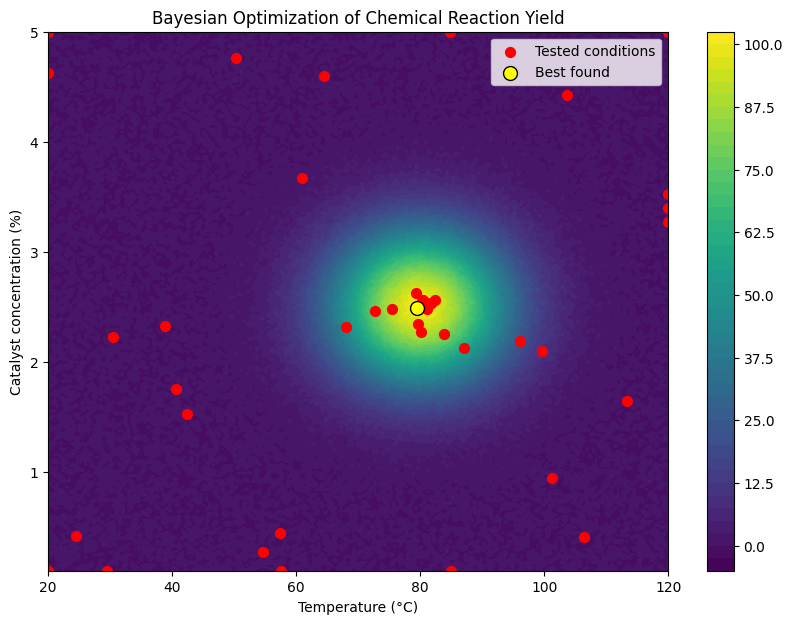

In [6]:
# Plot
plt.figure(figsize=(10, 7))
cp = plt.contourf(T_grid, C_grid, Z, levels=50, cmap=cm.viridis)
plt.colorbar(cp)

# Plot evaluated points
plt.scatter(X_total[:, 0], X_total[:, 1], c='red', s=50, label='Tested conditions')
best_idx = np.argmin(y_total)
plt.scatter(X_total[best_idx, 0], X_total[best_idx, 1], c='yellow', s=100, edgecolor='black', label='Best found')

# Labels
plt.title("Bayesian Optimization of Chemical Reaction Yield")
plt.xlabel("Temperature (°C)")
plt.ylabel("Catalyst concentration (%)")
plt.legend()
plt.show()
